<a href="https://colab.research.google.com/github/DataNata/Recommendation-system/blob/main/%22Recommend_system_InternetStores_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recommend system Internet Stores

In [62]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

In [63]:
df=pd.read_excel('/content/Sales_internet_store.xlsx')
df.head(3)

,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key,Product Price
0,95a9fe6f4810fcfc7ff244fd06784f11,2020-10-30 14:04:08 +0000,NaN,076e5854a62dd283c253d6bae415af1f,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,NaN,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,NaN,NaN,NaN,0353e63907dc0de0c734db4690300057,29.86
1,8d4d0330178d3ed181b15a4102b287f2,2020-08-06 05:51:47 +0000,NaN,8a4fe5d9c7a6ed26cc44d785a454b124,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,NaN,Clairol Nice 'N Easy Permanent Color 7/106A Na...,NaN,4.05,29221.0,NaN,b6985c8e94815fbca2319dbb8bf228af,1.07
2,fddc4df45b35efd886794b261f730c51,2020-07-15 11:22:04 +0000,NaN,03b5fb878a33eadff8b033419eab9669,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/25b4b467-bc61...,NaN,"Kokie Professional Matte Lipstick, Hot Berry, ...",NaN,NaN,NaN,NaN,85b70fded09186f00467cea2f935b779,1.05


In [64]:
df.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name', 'Sku',
       'Upc', 'Product Url', 'Market', 'Product Description',
       'Product Currency', 'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key',
       'Product Price'],
      dtype='object')

**1. Исследование данных и предпроцессинг**


In [65]:
df=df[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
df.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
1,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.05,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
2,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,NaN,NaN,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."


In [10]:
df['Product Tags']

,Product Tags
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
4996,"Garden Mint Room Spray (Double Strength), 4 ou..."
4997,Garnier Nutrisse Nourishing Hair Color Creme (...
4998,"Nail File Electric Drill, 6 in 1 Professional ..."
4999,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [66]:
df.shape

(3845, 10)

Определим количество пропусков  в данных

In [67]:
df.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,2059
Product Reviews Count,1164
Product Category,0
Product Brand,1
Product Name,0
Product Image Url,0
Product Description,0
Product Tags,1


In [68]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
df['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
df['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
df['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
df['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
df['Product Description'].fillna('', inplace=True)



<ipython-input-68-7fffeb14fa0e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Product Rating'].fillna(0, inplace=True)
<ipython-input-68-7fffeb14fa0e>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [69]:
#отфильтруем датафрейм - там где пустое значение по Product Id и по Product Tags
df=df[df['Product Id'].notna()]
df=df[df['Product Tags'].notna()]

In [70]:
df.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,0
Product Description,0
Product Tags,0


In [71]:
df.duplicated().sum()

np.int64(0)

In [72]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
df.rename(columns=column_name_mapping, inplace=True)

In [73]:
df.head(3)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.00,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
1,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.05,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
2,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,0.00,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."


In [74]:
#пребразуем значения в столбцах в числовые значения
df['ID'] = df['ID'].str.extract(r'(\d+)').astype(float)
df['ProdID'] = df['ProdID'].str.extract(r'(\d+)').astype(float)
df.head(3)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,95.0,76.0,0.00,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
1,8.0,8.0,4.05,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
2,4.0,3.0,0.00,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."


**2.Анализ данных -EDA**

In [75]:
#посмотрим основные статистические характеристики основных столбцов
num_users = df['ID'].nunique()
num_items = df['ProdID'].nunique()
num_ratings = df['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")




Number of unique users: 1375
Number of unique items: 1333
Number of unique ratings: 35


In [76]:
#посмотрим наиболее часто встречающиеся оценки

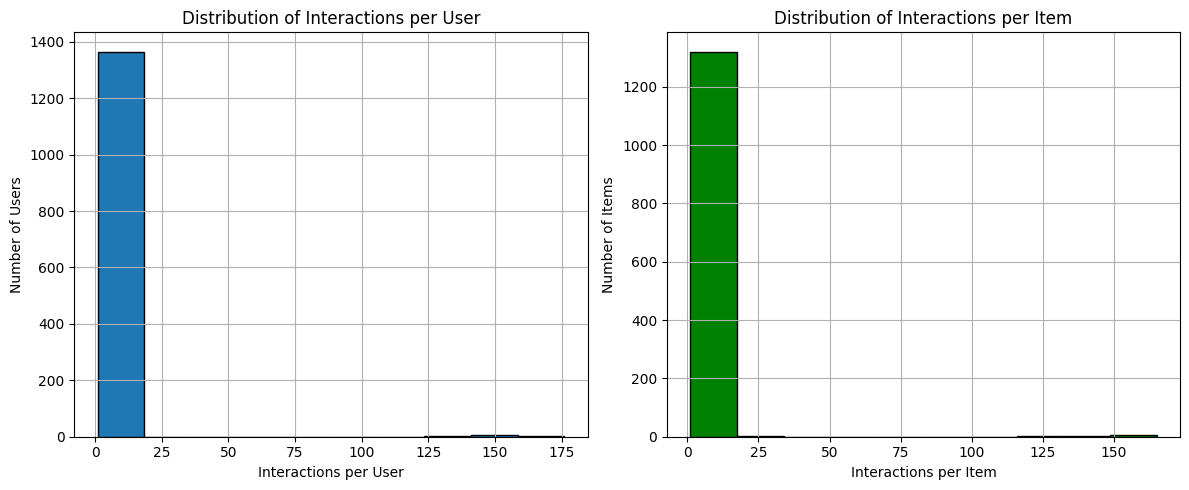

In [77]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
df['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

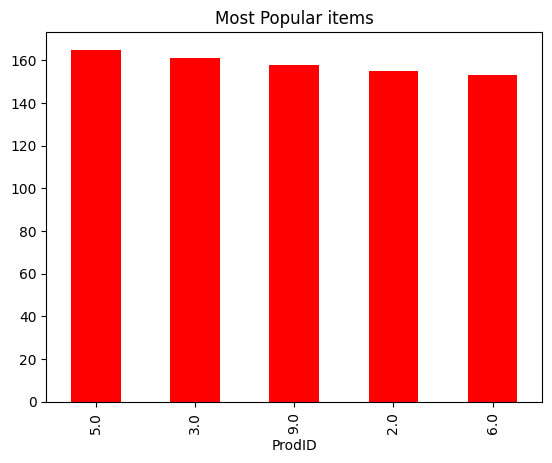

In [78]:
#посмотрим на 5 наиболее популярных продукта Интернет магазина
popular_items = df['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

In [79]:
#посмотрим на данный продукт
df1=df[df['ProdID']==5.0]
df1.head(5)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
44,3248.0,5.0,4.07,19.0,Personal Care > Bath & Body > Body Lotions & C...,SIMPLE WONDERS,100% Pure Aloe Vera Gel (5-Pack) - Organic Max...,https://i5.walmartimages.com/asr/a2c5c82e-6f82...,Our MAX HYDRATION Aloe Vera Gel formula will l...,100% Pure Aloe Vera Gel (5-Pack) - Organic Max...
45,8502.0,5.0,3.00,2.0,Personal Care > Feminine Care > All Feminine Care,Natracare,"Natracare Panty Liners, Ultra Thin, 22 Ct",https://i5.walmartimages.com/asr/df1af3dd-caea...,Natracare Organic Cotton Natural Panty Liners ...,"Natracare Panty Liners, Ultra Thin, 22 Ct, Wal..."
99,73.0,5.0,4.06,630.0,Beauty > Beauty by Top Brands > Milani > Milan...,Milani,"Milani Color Statement Lipstick, Sweet Nectar",https://i5.walmartimages.com/asr/4189c255-ac7e...,Enhance your look with this Milani Color State...,"Milani Color Statement Lipstick, Sweet Nectar,..."
109,9.0,5.0,0.00,3954.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,"Garnier Nutrisse Nourishing Hair Color Creme, ...",https://i5.walmartimages.com/asr/0bc0ea8b-8f81...,Garnier Nutrisse hair color creme nourishes wh...,"Garnier Nutrisse Nourishing Hair Color Creme, ..."
141,6.0,5.0,4.06,1588.0,Personal Care > Bath & Body > Body Wash & Show...,Mrs. Meyer's Clean Day,"Mrs. Meyers Clean Day Body Wash, RainWater Sce...",https://i5.walmartimages.com/asr/bd087742-f044...,Mrs. Meyers Clean Day body wash is specificall...,"Mrs. Meyer's Clean Day Body Wash, RainWater Sc..."


<Axes: xlabel='Rating'>

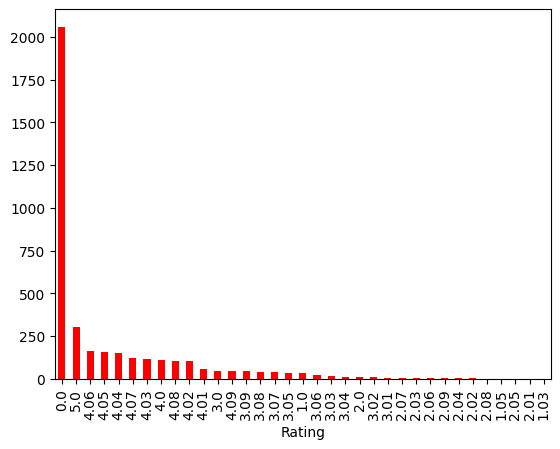

In [80]:
# most rated counts
df['Rating'].value_counts().plot(kind='bar',color='red')

In [81]:
rat=df['Rating'].unique()
print(rat)

[0.   4.05 4.06 4.03 5.   3.08 4.01 4.02 3.07 4.   4.07 4.09 4.04 2.
 3.09 3.   3.04 3.01 4.08 2.08 3.02 3.05 2.06 3.03 2.07 1.   3.06 2.03
 2.01 2.05 2.09 1.03 2.02 1.05 2.04]


**3.Подготовка и очистка данных**

In [82]:
df['Tags']

,Tags
0,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
1,Clairol Nice 'N Easy Permanent Color 7/106A Na...
2,"Kokie Professional Matte Lipstick, Hot Berry, ..."
3,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
4,Old Spice Artisan Styling High Hold Matte Fini...
...,...
3840,"Pure Gold Bitter Orange Essential Oil, 100% Na..."
3841,"Garden Mint Room Spray (Double Strength), 4 ou..."
3842,Garnier Nutrisse Nourishing Hair Color Creme (...
3843,"Nail File Electric Drill, 6 in 1 Professional ..."


In [83]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

In [84]:
def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    df[column] = df[column].apply(clean_and_extract_tags)

In [85]:
# Concatenate the cleaned tags from all relevant columns
df['Tags'] = df[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

**4.Rating Base Recommendations System**

In [96]:
average_ratings = df.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()
average_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         3839 non-null   object 
 1   ReviewCount  3839 non-null   float64
 2   Brand        3839 non-null   object 
 3   ImageURL     3839 non-null   object 
 4   Rating       3839 non-null   float64
dtypes: float64(2), object(3)
memory usage: 150.1+ KB


In [97]:
average_ratings

,Name,ReviewCount,Brand,ImageURL,Rating
0,$6 Mail-In Rebate Available Braun Epilator Sil...,146.0,braun,https://i5.walmartimages.com/asr/c7d78838-e8e2...,4.05
1,($11 Value) Love Beauty and Planet Coconut Wat...,278.0,"love, beauty, planet",https://i5.walmartimages.com/asr/0348d82d-2a13...,0.00
2,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.00
3,($14 Value) Burts Bees Beeswax Bounty Fruit Mi...,8.0,"burt, bees",https://i5.walmartimages.com/asr/0cb9a07f-a2be...,4.09
4,($23 Value) Carols Daughter Black Vanilla Cond...,377.0,"carol, daughter",https://i5.walmartimages.com/asr/5e0dcc63-2275...,4.04
...,...,...,...,...,...
3834,"wet n wild Photo Focus Correcting Palette, Col...",12.0,"wet, n, wild",https://i5.walmartimages.com/asr/750275fb-ccfa...,3.03
3835,"wet n wild Photo Focus Liquid Foundation, Medi...",7827.0,"wet, n, wild",https://i5.walmartimages.com/asr/c2c5dc7e-9bbb...,0.00
3836,"wet n wild Photo Focus Pressed Powder, Dark Café",635.0,"wet, n, wild",https://i5.walmartimages.com/asr/57bd497f-0d5c...,4.02
3837,"wet n wild Silk Finish Lipstick, Honolulu Is C...",4259.0,"wet, n, wild",https://i5.walmartimages.com/asr/0e25f705-a924...,3.09


In [99]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)
rating_base_recommendation

,Name,ReviewCount,Brand,ImageURL,Rating
2,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
3809,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
964,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
970,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0
974,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,"clay, park, labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0
869,"Cantu Moisturizing Cream Shampoo, 13.5 oz (Pac...",1.0,cantu,https://i5.walmartimages.com/asr/0a96aba2-949d...,5.0
871,Cantu Shea Butter for Natural Hair Conditionin...,4.0,cantu,https://i5.walmartimages.com/asr/819308b6-39c0...,5.0
876,Cardinal Health Protective Underpad Premium Ab...,1.0,"cardinal, health",https://i5.walmartimages.com/asr/c1a414c0-0aac...,5.0
3716,"Yardley London Moisturizing Bar, Lemon Verbena...",1.0,"yardley, london",https://i5.walmartimages.com/asr/6859e816-c0f2...,5.0
3731,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1.0,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5.0


In [100]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

<ipython-input-100-14a31ed65ba8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
<ipython-input-100-14a31ed65ba8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [101]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


<ipython-input-101-6e413a8a573d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]


,Name,ReviewCount,Brand,ImageURL,Rating
2,($14 Value) Burts Bees Beeswax Bounty Classic ...,10,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5
3809,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5
964,Clairol Professional Beautiful Collection Semi...,1,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5
970,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5
974,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13,"clay, park, labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5
869,"Cantu Moisturizing Cream Shampoo, 13.5 oz (Pac...",1,cantu,https://i5.walmartimages.com/asr/0a96aba2-949d...,5
871,Cantu Shea Butter for Natural Hair Conditionin...,4,cantu,https://i5.walmartimages.com/asr/819308b6-39c0...,5
876,Cardinal Health Protective Underpad Premium Ab...,1,"cardinal, health",https://i5.walmartimages.com/asr/c1a414c0-0aac...,5
3716,"Yardley London Moisturizing Bar, Lemon Verbena...",1,"yardley, london",https://i5.walmartimages.com/asr/6859e816-c0f2...,5
3731,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5


**5.Content Base Recommendation system (User Preferences or Items similarities)**

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(df['Tags'])

cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [103]:
cosine_similarities_content

array([[1.        , 0.37305655, 0.03850408, ..., 0.16444218, 0.02164932,
        0.03517055],
       [0.37305655, 1.        , 0.04501558, ..., 0.33948846, 0.03781644,
        0.05437563],
       [0.03850408, 0.04501558, 1.        , ..., 0.07309806, 0.01925467,
        0.03318697],
       ...,
       [0.16444218, 0.33948846, 0.07309806, ..., 1.        , 0.00502071,
        0.05200849],
       [0.02164932, 0.03781644, 0.01925467, ..., 0.00502071, 1.        ,
        0.03858822],
       [0.03517055, 0.05437563, 0.03318697, ..., 0.05200849, 0.03858822,
        1.        ]])

In [104]:
df.head(2)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,95.0,76.0,0.00,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
1,8.0,8.0,4.05,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."


In [109]:
df['Name'][0]

'Nice n Easy Permanent Color, 111 Natural Medium Auburn 1 ea (Pack of 3)'

In [110]:
item_name = 'Nice n Easy Permanent Color, 111 Natural Medium Auburn 1 ea (Pack of 3)'
item_index = df[df['Name']==item_name].index[0]

In [111]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [112]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [113]:
df.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
3479,"Nice n Easy Permanent Color, Natural Light Gol...",0.0,easy
3614,Natural Instincts Non-Permanent Color - 5A (Me...,1.0,"natural, instincts"
3644,Nice N Easy 112a Reddish Brown Hair Clr,314.0,"nice, n, easy"
2607,Clairol Nice n Easy Permanent Hair Color Creme...,28392.0,clairol
2698,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol
3599,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol
3045,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol
534,Clairol nice n easy permanent hair color 4/120...,29221.0,clairol
1749,Clairol Nicen Easy Permanent Hair Color Crème ...,27658.0,clairol


**6.Function To Recommend Products for Content Base**

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(df, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in df['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(df['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = df[df['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = df.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [116]:
# Example: Get content-based recommendations for a specific item
item_name = 'Nice n Easy Permanent Color, 111 Natural Medium Auburn 1 ea (Pack of 3)'
content_based_rec = content_based_recommendations(df, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3479,"Nice n Easy Permanent Color, Natural Light Gol...",0.0,easy,https://i5.walmartimages.com/asr/18856c22-d278...,0.00
3614,Natural Instincts Non-Permanent Color - 5A (Me...,1.0,"natural, instincts",https://i5.walmartimages.com/asr/b36d4d64-85cb...,5.00
3644,Nice N Easy 112a Reddish Brown Hair Clr,314.0,"nice, n, easy",https://i5.walmartimages.com/asr/92d814ab-fb18...,4.04
2607,Clairol Nice n Easy Permanent Hair Color Creme...,28392.0,clairol,https://i5.walmartimages.com/asr/52068b89-c6ed...,4.05
2698,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol,https://i5.walmartimages.com/asr/5d0e164e-86b6...,4.05
3599,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol,https://i5.walmartimages.com/asr/b42f3d34-5477...,4.05
3045,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol,https://i5.walmartimages.com/asr/2a775298-9f91...,4.05
534,Clairol nice n easy permanent hair color 4/120...,29221.0,clairol,https://i5.walmartimages.com/asr/924961cf-23ac...,4.05


In [117]:
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(df, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
2689,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.00
450,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.00
1953,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.07
3157,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.04
3184,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.00
1263,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.04
2299,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.04
2406,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.00


**7.Collaborative Filtering (User Item Similarity)**

In [118]:
user_item_matrix = df.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [119]:
user_item_matrix

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.005509e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,1,1,1,1,1,0,1,2,2,1,...,0,0,0,0,0,0,5,0,0,0
1.000000e+00,2,0,2,2,0,2,2,3,0,2,...,0,4,0,0,5,0,0,0,0,0
2.000000e+00,1,1,2,1,2,1,0,4,1,2,...,0,2,0,0,0,0,0,0,0,4
3.000000e+00,2,2,3,2,1,3,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4.000000e+00,2,0,2,2,1,2,0,3,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.799034e+12,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
8.186981e+12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.094514e+14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
user_similarity = cosine_similarity(user_item_matrix)

In [121]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [122]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [124]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = df[df['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [125]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
14,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.07
28,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.00
37,Medline Aloetouch PROTECT Dimethicone Skin Pro...,1.0,medline,https://i5.walmartimages.com/asr/ac8c39d4-4241...,2.00
52,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.03
55,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.02
60,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.00
72,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.00
79,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.00
94,6 Pack - Listerine 24-HR Tooth Sensitivity Rel...,1015.0,listerine,https://i5.walmartimages.com/asr/67345dd6-ba89...,4.05
113,Coconut Papaya Ultra Hydr. Shamp. by Bain de T...,0.0,"bain, de, terre",https://i5.walmartimages.com/asr/89d88ad7-5737...,0.00


**8.Function That Recommend Items**

In [126]:
def collaborative_filtering_recommendations(df, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = df.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = df[df['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(df, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
37,Medline Aloetouch PROTECT Dimethicone Skin Pro...,1.0,medline,https://i5.walmartimages.com/asr/ac8c39d4-4241...,2.00
52,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.03
72,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.00
120,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.00
129,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.00
135,Nutra-SX Master Cleanse- Maximum Blend- Aids H...,0.0,"nutra, sx",https://i5.walmartimages.com/asr/3b6b994d-e8a3...,0.00
143,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.00
160,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.05
176,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.00
204,royal jelly skin oil capsules by easycomforts ...,7.0,"amazing, shine",https://i5.walmartimages.com/asr/4d5fa59a-ff41...,0.00


**9.Hybrid Recommendations**

In [127]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(df,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(df,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(df,target_user_id, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(10)

In [128]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(df,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11' not found in the training data.
Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
37,Medline Aloetouch PROTECT Dimethicone Skin Pro...,1.0,medline,https://i5.walmartimages.com/asr/ac8c39d4-4241...,2.00
52,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.03
72,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.00
120,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.00
129,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.00
135,Nutra-SX Master Cleanse- Maximum Blend- Aids H...,0.0,"nutra, sx",https://i5.walmartimages.com/asr/3b6b994d-e8a3...,0.00
143,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.00
160,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.05
176,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.00
204,royal jelly skin oil capsules by easycomforts ...,7.0,"amazing, shine",https://i5.walmartimages.com/asr/4d5fa59a-ff41...,0.00


In [129]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(df,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
727,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.07
2027,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black, radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.03
2,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.00
2689,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.00
1953,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.07
3157,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.04
2299,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.04
3749,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.08
1054,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.01
343,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,"black, opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,0.00
